In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import os


In [3]:
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset

root = 'data'
name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name, root= root, transform=T.ToSparseTensor())

print(f"Dataset: {name}. Number of graphs: {len(dataset)}")

Dataset: ogbn-arxiv. Number of graphs: 1


In [4]:
data = dataset[0]
data

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])

Differently from a standard dataset in pytorch_geometric, here the Data attribute x is not the COO connectivity, rather the feature matrix X. The connectivity is in the adj_t variable. So there are a total of 169343 nodes, each one with a 128-dimensional feature vector.

In [5]:
data.adj_t = data.adj_t.to_symmetric()

In [37]:
print(torch.__version__)
print(torch.version.cuda)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
data.to(device)

2.2.2
None
Device: cpu


Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])

In [7]:
split_dict = dataset.get_idx_split() # built-in OGB splitter
split_dict

{'train': tensor([     0,      1,      2,  ..., 169145, 169148, 169251]),
 'valid': tensor([   349,    357,    366,  ..., 169185, 169261, 169296]),
 'test': tensor([   346,    398,    451,  ..., 169340, 169341, 169342])}

In [8]:
train_idx = split_dict['train']
train_idx.to(device) # also the indices are tensors
val_idx = split_dict['valid']
test_idx = split_dict['test']


## Model

We make it parametric, so that it will instantiate the number of layers based on a number passed as input. Thie following schematize the model:

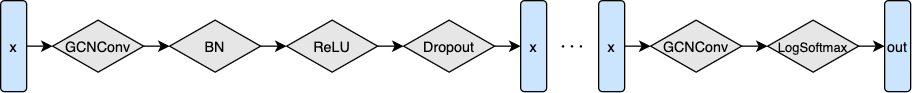

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, act_fn = F.relu, batch_norm = True, dropout = 0, return_embeddings = False) -> None:
        super(GCN, self).__init__()
        
        self.batch_norm = batch_norm
        self.act_fn = act_fn
        self.dropout = dropout
        self.prediction_head = torch.nn.LogSoftmax(dim=1)
        self.return_embeddings = return_embeddings
        
        # Initialize the convolution layers
        self.conv_layers = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)]) #first layer
        for _ in range(num_layers-2):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim)) #hidden layers
        self.conv_layers.append(GCNConv(hidden_dim, output_dim)) #last layer
        
        if batch_norm:
            self.batch_units = nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])
            
    
    def reset_parameters(self):
        for conv in self.conv_layers:
            conv.reset_parameters()
        if self.batch_norm:
            for b in self.batch_units:
                b.reset_parameters()
                

    def forward(self, x, edge_index):
        
        for l in range(len(self.conv_layers) - 1):
            x = F.dropout(self.act_fn(self.batch_units[l](self.conv_layers[l](x, edge_index))), p = self.dropout, training = True)
        
        # Final layer
        out = self.conv_layers[-1](x, edge_index) # Embeddings
        if not self.return_embeddings:
            out = self.prediction_head(out)  # Classification
        
        return out       
                
        

In [10]:
model = GCN(data.num_features,
            hidden_dim = 256,
            output_dim = dataset.num_classes,
            num_layers = 4)

In [11]:
for i, module in enumerate(model.modules()):
    print(i, '->', module)

0 -> GCN(
  (prediction_head): LogSoftmax(dim=1)
  (conv_layers): ModuleList(
    (0): GCNConv(128, 256)
    (1-2): 2 x GCNConv(256, 256)
    (3): GCNConv(256, 40)
  )
  (batch_units): ModuleList(
    (0-2): 3 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
1 -> LogSoftmax(dim=1)
2 -> ModuleList(
  (0): GCNConv(128, 256)
  (1-2): 2 x GCNConv(256, 256)
  (3): GCNConv(256, 40)
)
3 -> GCNConv(128, 256)
4 -> SumAggregation()
5 -> Linear(128, 256, bias=False)
6 -> GCNConv(256, 256)
7 -> SumAggregation()
8 -> Linear(256, 256, bias=False)
9 -> GCNConv(256, 256)
10 -> SumAggregation()
11 -> Linear(256, 256, bias=False)
12 -> GCNConv(256, 40)
13 -> SumAggregation()
14 -> Linear(256, 40, bias=False)
15 -> ModuleList(
  (0-2): 3 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
16 -> BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
17 -> BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True

## Training and Validation

OGB has also an Evaluator to assess the prformance of the model. We first compute the metrics as if Evaluator would not exist. Then, we also use it.

In [12]:
y_preds = model(data.x, data.adj_t)
y_preds

/users/anatali/miniconda3/envs/graphnets/lib/python3.12/site-packages/torch_sparse/tensor.py:574: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403246168/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(rowptr, col, value, self.sizes())


tensor([[-6.4012, -7.7873, -9.2531,  ..., -2.9236, -7.7304, -7.4354],
        [-4.5846, -4.7426, -4.4914,  ..., -3.1740, -3.9634, -3.4469],
        [-3.4448, -6.9034, -4.9559,  ..., -3.2877, -5.9135, -5.0332],
        ...,
        [-4.1622, -4.5818, -4.1953,  ..., -3.2897, -3.8775, -3.8222],
        [-4.1722, -4.8866, -4.8454,  ..., -3.1790, -4.7373, -4.2510],
        [-3.8608, -4.8809, -5.2945,  ..., -2.7713, -3.9164, -4.1986]],
       grad_fn=<LogSoftmaxBackward0>)

In [13]:
y_preds.argmax(dim=-1).float() # predictions with random weights

tensor([19.,  7., 31.,  ..., 22., 31.,  8.])

In [14]:
data.y.squeeze().long()

tensor([ 4,  5, 28,  ..., 10,  4,  1])

In [15]:
loss = F.nll_loss(y_preds.argmax(dim=-1).float(), data.y.squeeze().long())
loss

tensor(-16.)

We now actually train the network

In [16]:
import copy

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.reset_parameters()

for epoch in range(100):
    
    # Training
    model.train()
    optimizer.zero_grad()
    y_preds = model(data.x, data.adj_t) # notice how here it predicts in all the nodes
    
    loss = F.nll_loss(y_preds[train_idx], data.y[train_idx].squeeze().long()) # only computed on the train index
    loss.backward()
    optimizer.step()
    
    correct_train = (y_preds[train_idx].argmax(dim=-1) == data.y[train_idx].squeeze().long()).sum().item()
    total_train = len(train_idx)
    accuracy_train = correct_train / total_train
    
    
    # Validation
    best_val_acc = 0
    best_model = None
    with torch.no_grad(): # disable gradient tracking
        model.eval() # disables dropout and batch norm training
        # Differently from standard ML here the model has already made predictions on the validation examples, but they did not influence the loss
        correct_val = (y_preds[val_idx].argmax(dim=-1) == data.y[val_idx].squeeze().long()).sum().item()
        total_val = len(val_idx)
        accuracy_val = correct_val / total_val
        
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            best_model = copy.deepcopy(model)
        
    print(f"Epoch: {epoch}, Loss: {loss.item():.3f}, Train: {100 * accuracy_train:.4f}%, Valid: {100 * accuracy_val:.4f}%")
    

Epoch: 0, Loss: 4.160, Train: 1.1755%, Valid: 1.2651%
Epoch: 1, Loss: 3.365, Train: 17.1111%, Valid: 8.7419%
Epoch: 2, Loss: 2.849, Train: 35.2965%, Valid: 32.3971%
Epoch: 3, Loss: 2.524, Train: 44.3782%, Valid: 46.0888%
Epoch: 4, Loss: 2.297, Train: 49.8180%, Valid: 52.2232%
Epoch: 5, Loss: 2.126, Train: 53.2114%, Valid: 54.8508%
Epoch: 6, Loss: 1.993, Train: 55.5030%, Valid: 56.4918%
Epoch: 7, Loss: 1.889, Train: 57.2206%, Valid: 57.9046%
Epoch: 8, Loss: 1.806, Train: 58.5555%, Valid: 58.9751%
Epoch: 9, Loss: 1.736, Train: 59.5881%, Valid: 60.1228%
Epoch: 10, Loss: 1.675, Train: 60.6162%, Valid: 60.8779%
Epoch: 11, Loss: 1.622, Train: 61.3607%, Valid: 61.5960%
Epoch: 12, Loss: 1.577, Train: 61.9380%, Valid: 62.1766%
Epoch: 13, Loss: 1.538, Train: 62.5427%, Valid: 62.5994%
Epoch: 14, Loss: 1.502, Train: 63.0068%, Valid: 63.1229%
Epoch: 15, Loss: 1.469, Train: 63.4554%, Valid: 63.3947%
Epoch: 16, Loss: 1.438, Train: 64.0074%, Valid: 63.7303%
Epoch: 17, Loss: 1.408, Train: 64.5100%, Val

In this case, since we did not perform any hyperparameter tuning, there is no need to re-train all the model on training + validation data and then evaluate on the test data. We can simply pick the best validation score model and assess its performance in the test data, which in this case should be very similar to the validation one. 

# Using the Evaluator from ogb

In [24]:
model.reset_parameters()

In [25]:
def train(model, data, train_idx, optimizer, loss_fn):
    
    loss = 0
    model.train()
    optimizer.zero_grad()
    
    preds = model(data.x, data.adj_t)
    loss = loss_fn(preds[train_idx], data.y[train_idx].squeeze(dim=1).long())
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [33]:
import pandas as pd
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results = False):
    
    model.eval()
    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)
    
    # Evaluation
    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']
    
    if save_model_results:
        print ("Saving Model Predictions")

        data = {}
        data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

        df = pd.DataFrame(data=data)
        
        if not os.path.exists('predictions'):
            os.makedirs('predictions')
        
        # Save locally as csv
        df.to_csv('predictions/ogbn-arxiv_node.csv', sep=',', index=False)
        
    return train_acc, valid_acc, test_acc
    

In [34]:
args = {
    'device': device,
    'num_layers': 4,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}
args

{'device': 'cpu',
 'num_layers': 4,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 100}

In [36]:
from ogb.nodeproppred import Evaluator
evaluator = Evaluator(name = 'ogbn-arxiv')
model = GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            dropout = args['dropout']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = args['lr'])
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, data, train_idx, optimizer, loss_fn)
    result = test(model, data, split_dict, evaluator)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
            f'Loss: {loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 4.0237, Train: 23.43%, Valid: 28.00% Test: 25.10%
Epoch: 02, Loss: 2.4252, Train: 25.02%, Valid: 20.25% Test: 18.61%
Epoch: 03, Loss: 2.1185, Train: 32.05%, Valid: 37.66% Test: 39.43%
Epoch: 04, Loss: 1.9246, Train: 32.77%, Valid: 38.92% Test: 42.82%
Epoch: 05, Loss: 1.7551, Train: 38.01%, Valid: 40.87% Test: 42.14%
Epoch: 06, Loss: 1.6082, Train: 41.60%, Valid: 40.06% Test: 39.13%
Epoch: 07, Loss: 1.5586, Train: 41.27%, Valid: 36.81% Test: 37.90%
Epoch: 08, Loss: 1.5155, Train: 39.47%, Valid: 32.20% Test: 34.42%
Epoch: 09, Loss: 1.4573, Train: 38.05%, Valid: 32.63% Test: 35.73%
Epoch: 10, Loss: 1.4120, Train: 36.23%, Valid: 31.35% Test: 35.20%
Epoch: 11, Loss: 1.3859, Train: 34.87%, Valid: 29.61% Test: 33.31%
Epoch: 12, Loss: 1.3622, Train: 33.51%, Valid: 27.72% Test: 30.37%
Epoch: 13, Loss: 1.3302, Train: 31.45%, Valid: 24.87% Test: 26.00%
Epoch: 14, Loss: 1.3092, Train: 30.85%, Valid: 23.52% Test: 24.08%
Epoch: 15, Loss: 1.2846, Train: 31.31%, Valid: 24.68% Test: 25

In [38]:
best_result = test(best_model, data, split_dict, evaluator, save_model_results=True)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
    f'Train: {100 * train_acc:.2f}%, '
    f'Valid: {100 * valid_acc:.2f}% '
    f'Test: {100 * test_acc:.2f}%')

Saving Model Predictions
Best model: Train: 71.45%, Valid: 70.71% Test: 69.30%
